In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import random
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import os
import shutil
import string
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

use_cuda = False

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount("/content/gdrive", force_remount=True)
# drive.flush_and_unmount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Path

In [ ]:
# Shuyan
# drive_path = '/content/gdrive/My Drive/Documents/University Documents/Fourth Year/APS360/APS360 Project/'
# Shihang
drive_path = '/content/gdrive/My Drive/APS360/APS360 Project/'
# Evelyn
# drive_path = '/content/gdrive/My Drive/APS360H1 S/APS360 Project/'
# Zian
# drive_path = '/content/gdrive/My Drive/APS360H1 S/APS360 Project/'

In [ ]:
# archived_dataset_path = os.path.join(drive_path, "GTSRB_dataset", "archive")
dataset_path = os.path.join(drive_path, "GTSRB_dataset", "archive")
# archived_feature_path = os.path.join(drive_path, "Archived_ResNet_features")
feature_path = os.path.join(drive_path, "ResNet_features")

## /content

In [ ]:
import os
workdir = os.getcwd()

## [Don't Need Data] Load Data into /content

In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################
!cp -rv "$dataset_path" "$workdir"

流式输出内容被截断，只能显示最后 5000 行内容。
'/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/new/new_train/03/00003_00044_00029.png' -> '/content/new/new_train/03/00003_00044_00029.png'
'/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/new/new_train/03/00003_00003_00009.png' -> '/content/new/new_train/03/00003_00003_00009.png'
'/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/new/new_train/03/00003_00001_00013.png' -> '/content/new/new_train/03/00003_00001_00013.png'
'/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/new/new_train/03/00003_00026_00017.png' -> '/content/new/new_train/03/00003_00026_00017.png'
'/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/new/new_train/03/00003_00015_00007.png' -> '/content/new/new_train/03/00003_00015_00007.png'
'/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/new/new_train/03/00003_00005_00011.png' -> '/content/new/new_train/03/00003_00005_00011.png'
'/content/gdrive/My Drive/APS360/APS360 Pro

In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################
dataset_path = os.path.join(workdir, "new")

## [Need Embeddings] Load Embeddings into /content

In [ ]:
# !cp -rv "$archived_feature_path" "$workdir"
!cp -rv "$feature_path" "$workdir"

In [ ]:
train_path = os.path.join(workdir, "Archived_ResNet_features", "train")
valid_path = os.path.join(workdir, "Archived_ResNet_features", "valid")
test_path = os.path.join(workdir, "Archived_ResNet_features", "test")

new_train_path = os.path.join(workdir, "ResNet_features", "new_train")
new_valid_path = os.path.join(workdir, "ResNet_features", "new_val")
new_test_path = os.path.join(workdir, "ResNet_features", "new_test")

our_test_path = os.path.join(workdir, "ResNet_features", "our_test")

# Original Data Processing

In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################

# load train_val_set
train_val_path = f'{dataset_path}/Train'

train_val_set = torchvision.datasets.ImageFolder(train_val_path)

print(f'train_val_set size: {len(train_val_set)}')

updated_train_val_path = f'{dataset_path}/Updated_Train'
desired_size = (224, 224)

# limit to 300 images and add zero paddings
for class_id in range(43):
    # make the directory to hold updated data
    os.makedirs(
        os.path.join(updated_train_val_path, str(class_id)),
        exist_ok=True,
    )

    class_folder_path = os.path.join(train_val_path, str(class_id))

    if os.path.exists(class_folder_path):
        all_images = os.listdir(class_folder_path)
        if len(all_images) > 300:
            all_images = all_images[:300]

            print(f'Limited class {class_id} to 300 images')
        else:
            print(f'Class {class_id} has {len(all_images)} images')

        for image in all_images:
            print(f'Processing {image} in class {class_id}')

            image_path = os.path.join(class_folder_path, image)
            updated_class_path = os.path.join(updated_train_val_path, str(class_id))
            updated_image_path = os.path.join(updated_class_path, image)
            with Image.open(image_path) as img:
                # Add padding to the image
                old_size = img.size

                # Calculate the ratio of the desired size to the old size=
                ratio = float(desired_size[0])/max(old_size)
                new_size = tuple([int(x*ratio) for x in old_size])

                # Resize the image to new_size
                img = img.resize(new_size, Image.ANTIALIAS)

                # Create a new image with desired size and add zero padding
                new_im = Image.new("RGB", desired_size, (0, 0, 0))

                # Calculate the padding
                pad_w = (desired_size[0] - new_size[0]) // 2
                pad_h = (desired_size[0] - new_size[1]) // 2

                # Paste the resized image onto the center of the new image
                new_im.paste(img, (pad_w, pad_h))

                # new_size = max(old_size[0], desired_size[0]), max(old_size[1], desired_size[1])
                # new_im = Image.new("RGB", new_size, (0, 0, 0))
                # new_im.paste(img, ((new_size[0]-old_size[0])//2,
                #                   (new_size[1]-old_size[1])//2))

                # save the image:
                new_im.save(updated_image_path)
    else:
        print(f'Class folder {class_id} does not exist')

train_val_set size: 39229
Class 0 has 210 images
Processing 00000_00005_00000.png in class 0
Processing 00000_00006_00004.png in class 0
Processing 00000_00006_00007.png in class 0


<ipython-input-22-98d624dd964d>:57: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.ANTIALIAS)


流式输出内容被截断，只能显示最后 5000 行内容。
Processing 00025_00025_00002.png in class 25
Processing 00025_00002_00020.png in class 25
Processing 00025_00003_00014.png in class 25
Processing 00025_00016_00017.png in class 25
Processing 00025_00009_00020.png in class 25
Processing 00025_00018_00025.png in class 25
Processing 00025_00009_00027.png in class 25
Processing 00025_00012_00009.png in class 25
Processing 00025_00018_00008.png in class 25
Processing 00025_00007_00005.png in class 25
Processing 00025_00027_00019.png in class 25
Processing 00025_00001_00027.png in class 25
Processing 00025_00004_00019.png in class 25
Processing 00025_00020_00018.png in class 25
Processing 00025_00000_00012.png in class 25
Processing 00025_00020_00000.png in class 25
Processing 00025_00025_00023.png in class 25
Processing 00025_00023_00007.png in class 25
Processing 00025_00004_00001.png in class 25
Processing 00025_00004_00004.png in class 25
Processing 00025_00021_00016.png in class 25
Processing 00025_00017_00015

In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################

# resize and store test set

import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

# load train_val_set
test_path = f'{dataset_path}/Test'

updated_test_path = f'{dataset_path}/Updated_Test'
desired_size = (224, 224)

# configure test_set
test_path_load = f'{dataset_path}'
csv_file_path = f'{dataset_path}/Test.csv'
data = pd.read_csv(csv_file_path)

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, -1])
        # print("img_name:", img_name)
        image = Image.open(img_name)
        label = self.annotations.iloc[idx, -2]
        # print("label:", label)

        os.makedirs(
          os.path.join(updated_test_path, str(label)),
          exist_ok=True,
        )

        updated_class_path = os.path.join(updated_test_path, str(label))
        updated_image_path = os.path.join(updated_class_path, os.path.basename(img_name))

        # Add padding to the image
        old_size = image.size

        # Calculate the ratio of the desired size to the old size=
        ratio = float(desired_size[0])/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        # Resize the image to new_size
        img = image.resize(new_size, Image.ANTIALIAS)

        # Create a new image with desired size and add zero padding
        new_im = Image.new("RGB", desired_size, (0, 0, 0))

        # Calculate the padding
        pad_w = (desired_size[0] - new_size[0]) // 2
        pad_h = (desired_size[0] - new_size[1]) // 2

        # Paste the resized image onto the center of the new image
        new_im.paste(img, (pad_w, pad_h))

        # new_size = max(old_size[0], desired_size[0]), max(old_size[1], desired_size[1])
        # new_im = Image.new("RGB", new_size, (0, 0, 0))
        # new_im.paste(img, ((new_size[0]-old_size[0])//2,
        #                   (new_size[1]-old_size[1])//2))

        # save the image:
        new_im.save(updated_image_path)

        return new_im, label


# to test the loading of test_set
test_set = CustomDataset(csv_file=csv_file_path, root_dir=test_path_load)

# print(f'test_set size: {len(test_set)}')

# # to test the __getitem__ method
# for i in range(len(test_set)):
#     img, label = test_set[i]

<ipython-input-16-2377916a7ca8>:49: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = image.resize(new_size, Image.ANTIALIAS)


In [ ]:
def get_data_loader(batch_size):
    classes = list(range(0, 43))
    ########################################################################
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose([
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),  # Rotation
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  # Translation
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2)], p=0.5),  # Brightness Variation
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )])

    folder_names = os.listdir(updated_train_val_path)
    folder_names.sort(key=lambda x: int(x))  # Sort folder names by their integer value

    # Now you create a mapping from class names to indices
    class_to_idx = {cls_name: i for i, cls_name in enumerate(folder_names)}

    train_val_set = torchvision.datasets.ImageFolder(
        root=updated_train_val_path,
        transform=transform
    )

    train_val_set.class_to_idx = class_to_idx

    print(train_val_set.class_to_idx)

    print(f'train_val_set size: {len(train_val_set)}')

    # Get the list of indices to sample from
    relevant_train_val_indices = list(range(len(train_val_set)))

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_val_indices)
    split = int(len(relevant_train_val_indices) * 0.7) #split at 70%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_train_val_indices[:split], relevant_train_val_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_val_set, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(train_val_set, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )])

    # Load testing data
    test_set = torchvision.datasets.ImageFolder(
        root=updated_test_path,
        transform=transform_test
    )

    test_set.class_to_idx = class_to_idx

    print(test_set.class_to_idx)

    # Get the list of indices to sample from
    class_indices = {i: [] for i in range(43)}  # Dictionary to store indices for each class

    # Populate class_indices with indices for each class
    for idx, (_, label) in enumerate(test_set):
        class_indices[label].append(idx)

    sampled_indices = []
    for class_idx, indices in class_indices.items():
        if len(indices) >= 60:
            sampled_indices += list(np.random.choice(indices, size=60, replace=False))
        else:
            # Handle case where a class has less than 60 images
            sampled_indices += indices

    # Shuffle the combined list of indices
    np.random.shuffle(sampled_indices)

    # Create SubsetRandomSampler and DataLoader
    test_sampler = SubsetRandomSampler(sampled_indices)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    # print(f'test_set size: {len(test_set)}')

    # # Calculate sizes for splits
    # train_size = int(0.7 * len(train_val_set))
    # val_size = len(train_val_set) - train_size

    # print(train_size, val_size)

    # # Split the dataset
    # train_dataset, val_dataset = random_split(train_val_set, [train_size, val_size])
    # print(train_dataset.class_to_idx)
    # print(val_dataset.class_to_idx)

    # # Create data loaders
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader, classes

In [ ]:
updated_train_val_path = f'{dataset_path}/Updated_Train'
updated_test_path = f'{dataset_path}/Updated_Test'
train_loader, val_loader, test_loader, classes = get_data_loader(1)
# train_loader, val_loader, classes = get_data_loader(10)

torch.Size([224, 224, 3])


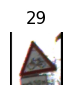

In [ ]:
#print a data batch
# print(train_val_set.class_to_idx)
shape = True
for images, labels in train_loader:
    for i in range(len(images)):
        img = np.transpose(images[i], (1, 2, 0))
        if shape == True:
          print(img.shape)
          shape = False
        img = img / 2 + 0.5
        plt.subplot(4, 8, i+1)
        plt.axis('off')
        plt.title(labels[i].item())
        # print(labels[i])
        plt.imshow(img)
    break

plt.show()

# New Data Processing

In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################

import os
import shutil

dataset_path = os.path.join(drive_path, "GTSRB_dataset", "archive")

updated_train_path = f'{dataset_path}/Updated_Train'
updated_test_path = f'{dataset_path}/Updated_Test'
new_train_path = f'{dataset_path}/new_train'
new_test_path = f'{dataset_path}/new_test'


os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# for folder_name in os.listdir(updated_train_path):
#     source_folder = os.path.join(updated_train_path, folder_name)
#     target_folder = os.path.join(new_train_path, folder_name)
#     os.makedirs(target_folder, exist_ok=True)
#     for file_name in os.listdir(source_folder):
#         source_file = os.path.join(source_folder, file_name)
#         target_file = os.path.join(target_folder, file_name)
#         shutil.copy2(source_file, target_file)


for folder_name in os.listdir(updated_test_path):
    source_folder = os.path.join(updated_test_path, folder_name)
    target_test_folder = os.path.join(new_test_path, folder_name)
    target_train_folder = os.path.join(new_train_path, folder_name)
    os.makedirs(target_test_folder, exist_ok=True)
    os.makedirs(target_train_folder, exist_ok=True)
    files = os.listdir(source_folder)
    for i, file_name in enumerate(files):
        source_file = os.path.join(source_folder, file_name)
        if i < 60:
            target_file = os.path.join(target_test_folder, file_name)
            shutil.copy2(source_file, target_file)
        else:
            target_file = os.path.join(target_train_folder, file_name)
            shutil.copy2(source_file, target_file)


In [ ]:
def get_data_loader(batch_size):
    classes = list(range(0, 43))
    ########################################################################
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose([
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),  # Rotation
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  # Translation
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2)], p=0.5),  # Brightness Variation
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )])

    folder_names = os.listdir(new_train_path)
    folder_names.sort(key=lambda x: int(x))  # Sort folder names by their integer value

    # Now you create a mapping from class names to indices
    class_to_idx = {cls_name: i for i, cls_name in enumerate(folder_names)}

    train_val_set = torchvision.datasets.ImageFolder(
        root=new_train_path,
        transform=transform
    )

    train_val_set.class_to_idx = class_to_idx

    print(train_val_set.class_to_idx)

    print(f'train_val_set size: {len(train_val_set)}')

    # Get the list of indices to sample from
    relevant_train_val_indices = list(range(len(train_val_set)))

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_val_indices)
    split = int(len(relevant_train_val_indices) * 0.7) #split at 70%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_train_val_indices[:split], relevant_train_val_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_val_set, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(train_val_set, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )])

    # Load testing data
    test_set = torchvision.datasets.ImageFolder(
        root=new_test_path,
        transform=transform_test
    )

    test_set.class_to_idx = class_to_idx

    print(test_set.class_to_idx)

    # Get the list of indices to sample from
    class_indices = {i: [] for i in range(43)}  # Dictionary to store indices for each class

    # Populate class_indices with indices for each class
    for idx, (_, label) in enumerate(test_set):
        class_indices[label].append(idx)

    sampled_indices = []
    for class_idx, indices in class_indices.items():
        if len(indices) >= 60:
            sampled_indices += list(np.random.choice(indices, size=60, replace=False))
        else:
            # Handle case where a class has less than 60 images
            sampled_indices += indices

    # Shuffle the combined list of indices
    np.random.shuffle(sampled_indices)

    # Create SubsetRandomSampler and DataLoader
    test_sampler = SubsetRandomSampler(sampled_indices)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    return train_loader, val_loader, test_loader, classes

In [ ]:
new_train_path = f'{dataset_path}/new_train'
new_test_path = f'{dataset_path}/new_test'

new_train_loader, new_val_loader, new_test_loader, classes = get_data_loader(1)

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}
train_val_set size: 22380
{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


# ResNet

In [ ]:
import torch
import torchvision.models as models

# Load pretrained RestNet-50 model
resnet_model = models.resnet50(pretrained=True)

# # Modify the last layer to output 43 classes
# num_features = resnet_model.fc.in_features
# resnet_model.fc = torch.nn.Linear(num_features, 43)

# # Freeze weights except final layer - feature extraction
# for param in resnet_model.parameters():
#     param.requires_grad = False

# Remove the final classification layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))

# Set model in evaluation mode
resnet_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################

def save_features(loader, path):
    count = 0
    for img, label in loader:
        # Ensure the input tensor is on the same device as the model
        # img = img.to(resnet_model.device)  # Assuming your model and data are on the same device
        # Compute features with no_grad to save memory and compute

        with torch.no_grad():
            features = resnet_model(img)

        # Convert features to a suitable format for saving
        features_tensor = torch.from_numpy(features.detach().numpy())

        # Save features
        folder_name = path + '/' + str(label.item())
        if not os.path.exists(folder_name):
          os.mkdir(folder_name)

        torch.save(features_tensor.squeeze(), folder_name + '/' + str(count) + '.tensor')
        count += 1

    print("Saved " + str(count) + " features.")

# save_features(train_loader, train_path)
# save_features(val_loader, valid_path)
# test_path = feature_path + '/test'
# save_features(test_loader, test_path)
# new_test_feature_path = f'{feature_path}/new_test'
# new_train_feature_path = f'{feature_path}/new_train'
new_val_feature_path = f'{feature_path}/new_val'

# save_features(new_test_loader, new_test_feature_path)
# save_features(new_train_loader, new_train_feature_path)
save_features(new_val_loader, new_val_feature_path)

Saved 6715 features.


# Classifier

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc1 = nn.Linear(2048, 1500)
        self.fc2 = nn.Linear(1500, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = F.relu(self.fc1(flattened))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(CNN_dropout, self).__init__()
        self.name = "CNN_dropout"
        # input dimension would be 1*2048
        self.fc1 = nn.Linear(2048, 1500)
        self.dropout1 = nn.Dropout(dropout_p)  # Dropout layer after fc1
        self.fc2 = nn.Linear(1500, 1000)
        self.dropout2 = nn.Dropout(dropout_p)  # Dropout layer after fc2
        self.fc3 = nn.Linear(1000, 500)
        self.dropout3 = nn.Dropout(dropout_p)  # Dropout layer after fc3
        self.fc4 = nn.Linear(500, 100)
        self.dropout4 = nn.Dropout(dropout_p)  # Dropout layer after fc4
        self.fc5 = nn.Linear(100, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = F.relu(self.fc1(flattened))
        x = self.dropout1(x)  # Apply dropout after activation
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after activation
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)  # Apply dropout after activation
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)  # Apply dropout after activation
        x = self.fc5(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x


In [ ]:
class CNN_simpler(nn.Module):
    def __init__(self):
        super(CNN_simpler, self).__init__()
        self.name = "CNN_simpler" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 43)
        )

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class CNN_simplest(nn.Module):
    def __init__(self):
        super(CNN_simplest, self).__init__()
        self.name = "CNN_simplest" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc = nn.Linear(2048, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_dropout_simpler(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(CNN_dropout_simpler, self).__init__()
        self.name = "CNN_dropout_simpler"
        # input dimension would be 1*2048
        self.fc1 = nn.Linear(2048, 512)
        self.dropout1 = nn.Dropout(dropout_p)  # Dropout layer after fc1
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_p)  # Dropout layer after fc2
        self.fc3 = nn.Linear(128, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = F.relu(self.fc1(flattened))
        x = self.dropout1(x)  # Apply dropout after activation
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after activation
        x = self.fc3(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x

# Training and Plotting

In [ ]:
def get_accuracy(data, model):
    correct = 0
    total = 0
    for imgs, labels in data:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        # #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification accuracy over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage - put imgs and labels (data) under GPU memory, cuda is NVidia GPU framework
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        corr = pred.eq(labels.view_as(pred))
        total_acc += corr.sum().item()
        total_loss += loss.item()
        total_epoch += inputs.shape[0]
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

def get_model_name(batch_size, learning_rate, epoch, name="CNN", drive_path=drive_path):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "{0}Primary_checkpoint/model_{1}_bs{2}_lr{3}_epoch{4}".format(drive_path,
                                                                          name,
                                                                          batch_size,
                                                                          learning_rate,
                                                                          epoch)
    return path


In [ ]:
def train(model, dataset_train, dataset_val, batch_size=32, num_epochs=10, learning_rate = 0.01):

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train_data = train_RestNet_loader
    # val_data = val_RestNet_loader
    print("Data loaded, start training. ")
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        i = 0
        for features, labels in iter(dataloader_train):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
              # print("GPU enabled")
            # #############################################
            out = model(features)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Evaluate
            total_train_loss += loss.item()
            pred = out.max(1, keepdim=True)[1]
            total_train_acc += pred.eq(labels.view_as(pred)).sum().item()
            total_epoch += features.shape[0]
            i += 1

        # save the current training information
        train_acc[epoch] = float(total_train_acc) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(model, dataloader_val, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(batch_size, learning_rate, epoch, name=model.name)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/val loss/acc into CSV file for plotting later
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    # PLOT LATER USING plot_training_curve
    # # plotting
    # plt.title("Training Curve")
    # plt.plot(iters, losses, label="Train")
    # plt.xlabel("Iterations")
    # plt.ylabel("Loss")
    # plt.show()

    # plt.title("Training Curve")
    # plt.plot(iters, train_acc, label="Train")
    # plt.plot(iters, val_acc, label="Validation")
    # plt.xlabel("Iterations")
    # plt.ylabel("Training Accuracy")
    # plt.legend(loc='best')
    # plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Hyperparameter Tuning

## Model 1

In [ ]:
use_cuda = True
model1 = CNN()
model1.name = 'model1'
if use_cuda and torch.cuda.is_available():
  model1.cuda()

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
# test_RestNet_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

batch_size = 64

In [ ]:
train(model1, train_RestNet_dataset, val_RestNet_dataset, batch_size=batch_size, num_epochs=20, learning_rate = 0.01)

Data loaded, start training. 
Epoch 1: Train acc: 0.05642451627853088, Train loss: 3.554448194363538 |Validation acc: 0.12534171678512848, Validation loss: 2.6470250627268914
Epoch 2: Train acc: 0.1948789248059321, Train loss: 2.332522427334505 |Validation acc: 0.24220885729907052, Validation loss: 2.2465681957161947
Epoch 3: Train acc: 0.2897694357548372, Train loss: 2.012648386113784 |Validation acc: 0.32189721159103335, Validation loss: 1.8924234100010084
Epoch 4: Train acc: 0.35268219209825047, Train loss: 1.8121120289844626 |Validation acc: 0.3813559322033898, Validation loss: 1.718032345564469
Epoch 5: Train acc: 0.39752056540377706, Train loss: 1.656836516716901 |Validation acc: 0.4338436303991252, Validation loss: 1.5838290857232136
Epoch 6: Train acc: 0.4357548372146912, Train loss: 1.550830000463654 |Validation acc: 0.41798797156916345, Validation loss: 1.642605768079343
Epoch 7: Train acc: 0.4554512802687985, Train loss: 1.4709518420345642 |Validation acc: 0.4130672498633133

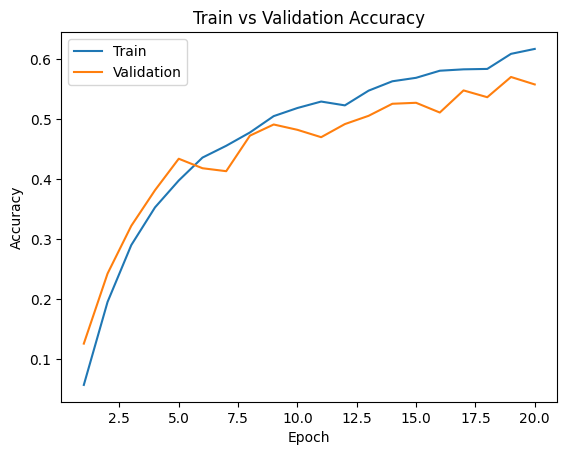

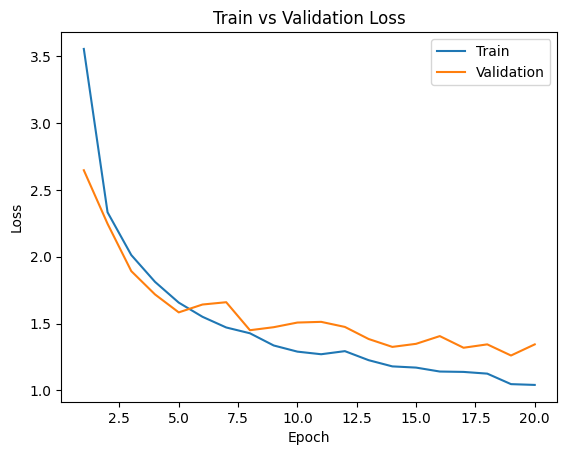

In [ ]:
model_path = get_model_name(name="model1",
                            batch_size=64,
                            learning_rate=0.01,
                            epoch=19)

plot_training_curve(model_path)

## Model 2

## Model 3

In [ ]:
use_cuda = True
model3 = CNN()
model3.name = 'model3'
if use_cuda and torch.cuda.is_available():
  model3.cuda()

train_RestNet_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
# test_RestNet_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

batch_size = 64

In [ ]:
train(model3, train_RestNet_dataset, val_RestNet_dataset, batch_size=batch_size, num_epochs=50, learning_rate = 0.01)

Data loaded, start training. 
Epoch 1: Train acc: 0.07600509790290812, Train loss: 3.346790012191324 |Validation acc: 0.13340623291416073, Validation loss: 2.541573026905889
Epoch 2: Train acc: 0.2024099177383849, Train loss: 2.312275504364687 |Validation acc: 0.2647621651175506, Validation loss: 2.083602805759596
Epoch 3: Train acc: 0.2981114586954003, Train loss: 1.9672649318681044 |Validation acc: 0.3333788955713505, Validation loss: 1.8877041640488998
Epoch 4: Train acc: 0.34515119916579773, Train loss: 1.787646852871951 |Validation acc: 0.36659376708583924, Validation loss: 1.7599832825038744
Epoch 5: Train acc: 0.3942764453713359, Train loss: 1.6431306723286123 |Validation acc: 0.36932750136686715, Validation loss: 1.6912598381871762
Epoch 6: Train acc: 0.408179816938941, Train loss: 1.5978792090626324 |Validation acc: 0.3940677966101695, Validation loss: 1.69669044121452
Epoch 7: Train acc: 0.45336577453365773, Train loss: 1.460104466361158 |Validation acc: 0.4555768179332969, V

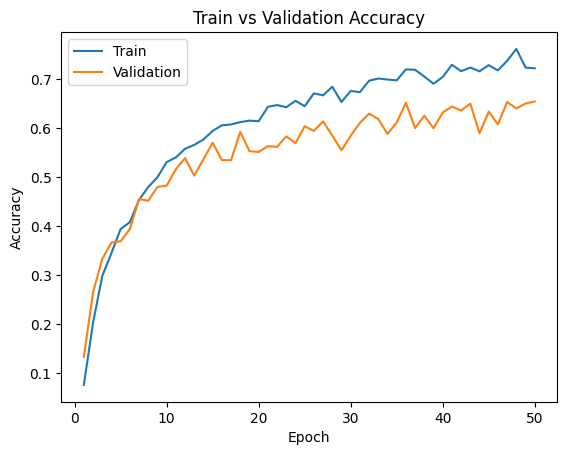

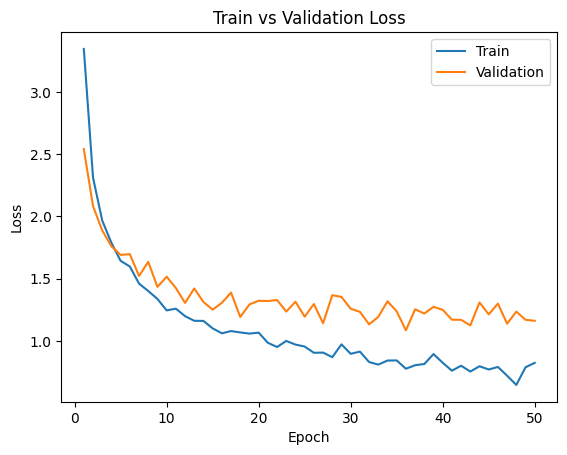

In [ ]:
model_path = get_model_name(name="model3",
                            batch_size=64,
                            learning_rate=0.01,
                            epoch=49)

plot_training_curve(model_path)

## Model 4

In [ ]:
use_cuda = True
model4 = CNN()
model4.name = 'model4'
if use_cuda and torch.cuda.is_available():
  model4.cuda()

train_RestNet_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
# test_RestNet_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

batch_size = 128

In [ ]:
train(model4, train_RestNet_dataset, val_RestNet_dataset, batch_size=batch_size, num_epochs=50, learning_rate = 0.01)

Data loaded, start training. 
Epoch 1: Train acc: 0.052021781948789245, Train loss: 3.4725198158319444 |Validation acc: 0.08119190814652816, Validation loss: 2.829926400349058
Epoch 2: Train acc: 0.1291854941489978, Train loss: 2.552034288212873 |Validation acc: 0.20571350464734828, Validation loss: 2.3017619560504783
Epoch 3: Train acc: 0.26740817981693893, Train loss: 2.0775392936623613 |Validation acc: 0.30522143247676325, Validation loss: 1.9372502750363843
Epoch 4: Train acc: 0.3880199281659136, Train loss: 1.6787052016327346 |Validation acc: 0.38258611262985237, Validation loss: 1.8667302748252605
Epoch 5: Train acc: 0.4307727957362994, Train loss: 1.5387331765630972 |Validation acc: 0.40472936030617823, Validation loss: 1.789185141694957
Epoch 6: Train acc: 0.4832580234040088, Train loss: 1.400682440702466 |Validation acc: 0.47279934390377254, Validation loss: 1.4462923756961166
Epoch 7: Train acc: 0.5239253852392538, Train loss: 1.2813995022704636 |Validation acc: 0.52104975396

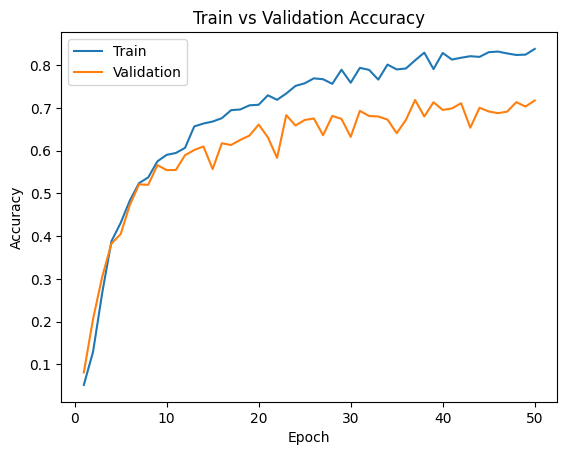

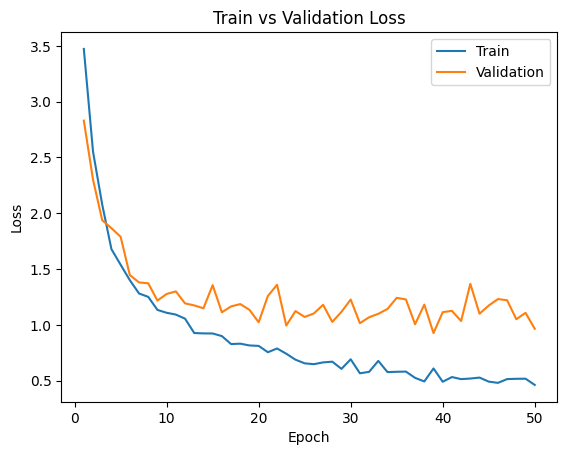

In [ ]:
model_path = get_model_name(name="model4",
                            batch_size=128,
                            learning_rate=0.01,
                            epoch=49)

plot_training_curve(model_path)

## Model 5

In [ ]:
use_cuda = True
model_new_test = CNN()
model_new_test.name = 'model_new_test'
if use_cuda and torch.cuda.is_available():
  model_new_test.cuda()

train_RestNet_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
# test_RestNet_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

batch_size = 512

In [ ]:
train(model_new_test, train_RestNet_dataset, val_RestNet_dataset, batch_size=batch_size, num_epochs=80, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.04205769899200556, Train loss: 3.306159112188551 |Validation acc: 0.061372334609076, Validation loss: 3.0920593897501627
Epoch 2: Train acc: 0.09778704669215618, Train loss: 2.663557661904229 |Validation acc: 0.1273920174958994, Validation loss: 2.7146634419759113
Epoch 3: Train acc: 0.16938941026532267, Train loss: 2.36111933655209 |Validation acc: 0.22676325861126298, Validation loss: 2.2861299991607664
Epoch 4: Train acc: 0.2722743598656007, Train loss: 2.0001623498068914 |Validation acc: 0.32586112629852376, Validation loss: 1.9429770151774088
Epoch 5: Train acc: 0.3646159193604449, Train loss: 1.7127293083402846 |Validation acc: 0.3909240021869874, Validation loss: 1.7511779546737671
Epoch 6: Train acc: 0.42474800139033714, Train loss: 1.5353690650728014 |Validation acc: 0.4384909786768726, Validation loss: 1.5607921759287515
Epoch 7: Train acc: 0.49009384775808135, Train loss: 1.3399777876006231 |Validation acc: 0.52337342810278

In [ ]:
use_cuda = True
model_new_test = CNN_simpler()
model_new_test.name = 'model_new_train_1'
if use_cuda and torch.cuda.is_available():
  model_new_test.cuda()

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))
# test_RestNet_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

batch_size = 512

In [ ]:
train(model_new_test, train_RestNet_dataset, val_RestNet_dataset, batch_size=batch_size, num_epochs=100, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.14413161858417334, Train loss: 2.816214640935262 |Validation acc: 0.3044013121924549, Validation loss: 2.2369614124298094
Epoch 2: Train acc: 0.3800254895145406, Train loss: 1.7836362388398912 |Validation acc: 0.43069983597594313, Validation loss: 1.657607920964559
Epoch 3: Train acc: 0.5299501795852161, Train loss: 1.3135773142178853 |Validation acc: 0.5608255877528704, Validation loss: 1.2869089682896933
Epoch 4: Train acc: 0.6368902792260457, Train loss: 1.0306766364309523 |Validation acc: 0.6038819026790596, Validation loss: 1.1567200263341268
Epoch 5: Train acc: 0.6949368555207971, Train loss: 0.8613376683659024 |Validation acc: 0.6565062875888463, Validation loss: 1.0310105840365091
Epoch 6: Train acc: 0.7389641988182134, Train loss: 0.7309724357393053 |Validation acc: 0.6947785675232367, Validation loss: 0.9020686229070027
Epoch 7: Train acc: 0.7785888077858881, Train loss: 0.6213816271887885 |Validation acc: 0.702159650082012,

# Our Test Data Processing

In [ ]:
# resize and store updated our test set
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################

# load train_val_set
our_test_path = f'{dataset_path}/our_test_set'

# our_test_set = torchvision.datasets.ImageFolder(our_test_path)

# print(f'train_val_set size: {len(our_test_set)}')

updated_our_test_path = f'{dataset_path}/Updated_our_test'
desired_size = (224, 224)

#add zero paddings
for class_id in range(43):
    # make the directory to hold updated data
    os.makedirs(
        os.path.join(updated_our_test_path, str(class_id)),
        exist_ok=True,
    )

    class_folder_path = os.path.join(our_test_path, str(class_id))

    if os.path.exists(class_folder_path):
        all_images = os.listdir(class_folder_path)

        for image in all_images:
            print(f'Processing {image} in class {class_id}')

            image_path = os.path.join(class_folder_path, image)
            updated_class_path = os.path.join(updated_our_test_path, str(class_id))
            updated_image_path = os.path.join(updated_class_path, image)
            with Image.open(image_path) as img:
                # Add padding to the image
                old_size = img.size

                # Calculate the ratio of the desired size to the old size=
                ratio = float(desired_size[0])/max(old_size)
                new_size = tuple([int(x*ratio) for x in old_size])

                # Resize the image to new_size
                img = img.resize(new_size, Image.ANTIALIAS)

                # Create a new image with desired size and add zero padding
                new_im = Image.new("RGB", desired_size, (0, 0, 0))

                # Calculate the padding
                pad_w = (desired_size[0] - new_size[0]) // 2
                pad_h = (desired_size[0] - new_size[1]) // 2

                # Paste the resized image onto the center of the new image
                new_im.paste(img, (pad_w, pad_h))

                # new_size = max(old_size[0], desired_size[0]), max(old_size[1], desired_size[1])
                # new_im = Image.new("RGB", new_size, (0, 0, 0))
                # new_im.paste(img, ((new_size[0]-old_size[0])//2,
                #                   (new_size[1]-old_size[1])//2))

                # save the image:
                new_im.save(updated_image_path)
    else:
        print(f'Class folder {class_id} does not exist')

Processing 0-5.jpeg in class 0
Processing 0-1.jpeg in class 0
Processing 0-2.jpeg in class 0
Processing 0-3.jpeg in class 0
Processing 0-4.jpeg in class 0
Processing 1-1.jpeg in class 1
Processing 1-2.jpeg in class 1
Processing 1-3.jpeg in class 1
Processing 1-4.jpeg in class 1
Processing 1-5.jpeg in class 1


<ipython-input-60-0c8d905b5dcd>:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.ANTIALIAS)


Processing 2-1.jpeg in class 2
Processing 2-2.jpeg in class 2
Processing 2-3.jpeg in class 2
Processing 2-4.jpeg in class 2
Processing 2-5.jpeg in class 2
Processing 3-1.jpeg in class 3
Processing 3-2.jpeg in class 3
Processing 3-3.jpeg in class 3
Processing 3-4.jpeg in class 3
Processing 3-5.jpeg in class 3
Processing 4-1.jpeg in class 4
Processing 4-2.jpeg in class 4
Processing 4-3.jpeg in class 4
Processing 5-1.jpeg in class 5
Processing 5-2.jpeg in class 5
Processing 5-3.jpeg in class 5
Processing 5-4.jpeg in class 5
Processing 5-5.jpeg in class 5
Processing 6-1.jpeg in class 6
Processing 6-2.jpeg in class 6
Processing 6-3.jpeg in class 6
Processing 7-1.jpeg in class 7
Processing 7-2.jpeg in class 7
Processing 7-3.jpeg in class 7
Processing 7-4.jpeg in class 7
Processing 7-5.jpeg in class 7
Processing 8-1.jpeg in class 8
Processing 8-2.jpeg in class 8
Processing 8-3.jpeg in class 8
Processing 8-4.jpeg in class 8
Processing 8-5.jpeg in class 8
Processing 9-1.jpeg in class 9
Processi

In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################

# load our test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
)])

folder_names = os.listdir(updated_our_test_path)
folder_names.sort(key=lambda x: int(x))  # Sort folder names by their integer value

# Now you create a mapping from class names to indices
class_to_idx = {cls_name: i for i, cls_name in enumerate(folder_names)}

# Load testing data
our_test_set = torchvision.datasets.ImageFolder(
                    root=updated_our_test_path,
                    transform=transform_test
                )

our_test_set.class_to_idx = class_to_idx

print(our_test_set.class_to_idx)

# Get the list of indices to sample from
relevant_our_test_set_indices = list(range(len(our_test_set)))
batch_size=1

np.random.shuffle(relevant_our_test_set_indices)
our_test_sampler = SubsetRandomSampler(relevant_our_test_set_indices)
our_test_loader = torch.utils.data.DataLoader(our_test_set, batch_size=batch_size,
                                            num_workers=1, sampler=our_test_sampler)

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


In [ ]:
####################### ATTENTION!!! ##########################
####################### DON'T RUN THIS!!!! #######################


# our_test_path = feature_path + '/our_test'
# save_features(our_test_loader, our_test_path)

Saved 244 features.


# **Load Best Model**

In [ ]:
best_batch_size = 128

best_model = CNN()
best_model.name = "best_model"
best_path = get_model_name(batch_size=best_batch_size,
                           learning_rate=0.003,
                           epoch=49,
                           name="model10_new")
state = torch.load(best_path)
best_model.load_state_dict(state)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/APS360/APS360 Project/Primary_checkpoint/model_model_3_SR_bs128_lr0.001_epoch79'

# ["Load Best Model" First] Test Model Performance

## Database Test

In [ ]:
test_RestNet_dataset = torchvision.datasets.DatasetFolder(new_test_path, loader=torch.load, extensions=('.tensor'))
dataloader_test = torch.utils.data.DataLoader(test_RestNet_dataset, batch_size=best_batch_size, shuffle=True)

test_acc, test_loss = evaluate(best_model, dataloader_test, nn.CrossEntropyLoss())
print(f"test accuracy = {test_acc*100:.2f}% | test loss = {test_loss}")

test accuracy = 0.6000759589821496 | test loss = 2.470185887245905


## Our Test

In [ ]:
test_our_dataset = torchvision.datasets.DatasetFolder(our_test_path, loader=torch.load, extensions=('.tensor'))
dataloader_our_test = torch.utils.data.DataLoader(test_our_dataset, batch_size=best_batch_size, shuffle=True)

our_test_acc, our_test_loss = evaluate(best_model, dataloader_our_test, nn.CrossEntropyLoss())
print(f"our test accuracy = {our_test_acc*100:.2f}% | our test loss = {our_test_loss}")

our test accuracy = 0.319672131147541 | our test loss = 5.792903423309326


## Combined Test

In [ ]:
test_RestNet_dataset = torchvision.datasets.DatasetFolder(new_test_path, loader=torch.load, extensions=('.tensor'))
test_our_dataset = torchvision.datasets.DatasetFolder(our_test_path, loader=torch.load, extensions=('.tensor'))

test_combined_dataset = torch.utils.data.ConcatDataset([test_RestNet_dataset, test_our_dataset])
dataloader_combined_test = torch.utils.data.DataLoader(test_combined_dataset, batch_size=best_batch_size, shuffle=True)

combined_test_acc, combined_test_loss = evaluate(best_model, dataloader_combined_test, nn.CrossEntropyLoss())
print(f"combined test accuracy = {combined_test_acc*100:.2f}% | combined test loss = {combined_test_loss}")

# Get Label-Class Mapping

In [ ]:
train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
class_to_idx = train_RestNet_dataset.class_to_idx

idx_to_class = {idx: int(class_name) for class_name, idx in class_to_idx.items()}
print(idx_to_class)

{0: 0, 1: 1, 2: 10, 3: 11, 4: 12, 5: 13, 6: 14, 7: 15, 8: 16, 9: 17, 10: 18, 11: 19, 12: 2, 13: 20, 14: 21, 15: 22, 16: 23, 17: 24, 18: 25, 19: 26, 20: 27, 21: 28, 22: 29, 23: 3, 24: 30, 25: 31, 26: 32, 27: 33, 28: 34, 29: 35, 30: 36, 31: 37, 32: 38, 33: 39, 34: 4, 35: 40, 36: 41, 37: 42, 38: 5, 39: 6, 40: 7, 41: 8, 42: 9}


# ["Load Best Model" & "Get Label-Class Mapping" First] One Image Test

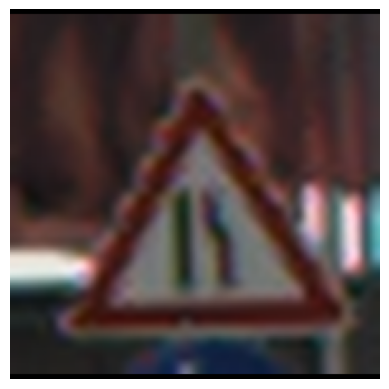

In [ ]:
# simply pick a class
random_class_label = random.randint(0, 42)
random_class = f'{random_class_label:02d}'

test_class_path = os.path.join(dataset_path, "new_test", random_class)
test_class_images = os.listdir(test_class_path)

# simply pick an image
num_images = len(test_class_images)
random_image = random.randint(0, num_images)
test_image_file = test_class_images[random_image]

test_image_path = os.path.join(test_class_path, test_image_file)

# read the image
test_image = img.imread(test_image_path)
# display the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [ ]:
# load image into tensor
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
)])

test_image = Image.open(test_image_path)
test_image = transform_test(test_image).unsqueeze(0)

import torchvision.models as models
# Load pretrained RestNet-50 model
resnet_model = models.resnet50(pretrained=True)
# Remove the final classification layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
# Set model in evaluation mode
resnet_model.eval()

# pass image into ResNet
with torch.no_grad():
    test_feature = resnet_model(test_image)
test_feature = test_feature.squeeze().unsqueeze(0)

# predict label of image
onehot_prediction = best_model(test_feature)
onehot_prediction = onehot_prediction.squeeze()

# get the predicted class
class_prediction = onehot_prediction.argmax()
class_prediction = class_prediction.item()
class_prediction = idx_to_class[class_prediction]

# compare predicted class and actual class
print(f"predicted class = {class_prediction} | actual class = {random_class_label}")
if class_prediction == random_class_label:
    print("Yes! The prediction of our model is correct.")
else:
    print("No! The prediction of our model is wrong.")

predicted class = 24 | actual class = 24
Yes! The prediction of our model is correct.


#Our test set One Image Test

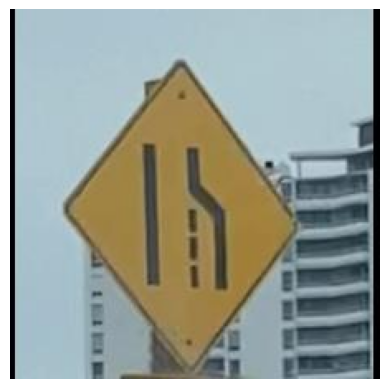

In [ ]:
# simply pick a class
random_class_label = random.randint(0, 42)
random_class = f'{random_class_label:02d}'

test_class_path = os.path.join(dataset_path, "Updated_our_test", random_class)
test_class_images = os.listdir(test_class_path)

# simply pick an image
num_images = len(test_class_images)
random_image = random.randint(0, num_images)
test_image_file = test_class_images[random_image]

test_image_path = os.path.join(test_class_path, test_image_file)

# read the image
test_image = img.imread(test_image_path)
# display the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [ ]:
# load image into tensor
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
)])

test_image = Image.open(test_image_path)
test_image = transform_test(test_image).unsqueeze(0)

import torchvision.models as models
# Load pretrained RestNet-50 model
resnet_model = models.resnet50(pretrained=True)
# Remove the final classification layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
# Set model in evaluation mode
resnet_model.eval()

# pass image into ResNet
with torch.no_grad():
    test_feature = resnet_model(test_image)
test_feature = test_feature.squeeze().unsqueeze(0)

# predict label of image
onehot_prediction = best_model(test_feature)
onehot_prediction = onehot_prediction.squeeze()

# get the predicted class
class_prediction = onehot_prediction.argmax()
class_prediction = class_prediction.item()
class_prediction = idx_to_class[class_prediction]

# compare predicted class and actual class
print(f"predicted class = {class_prediction} | actual class = {random_class_label}")
if class_prediction == random_class_label:
    print("Yes! The prediction of our model is correct.")
else:
    print("No! The prediction of our model is wrong.")

predicted class = 24 | actual class = 24
Yes! The prediction of our model is correct.


# ["Load Best Model" & "Get Label-Class Mapping" First] Confusion Matrix

In [ ]:
def get_labels_and_predictions(model, loader, limit=False):
  labels_list = []
  predictions_list = []
  for data in loader:
      inputs, labels = data
      predictions = model(inputs)
      labels_list += labels.clone().detach().numpy().flatten().tolist()
      predictions_list += np.argmax(predictions.clone().detach().numpy(), axis=1).tolist()
      if limit:
        break

  # map labels and predictions to classes
  class_labels_list = [idx_to_class[idx] for idx in labels_list]
  class_predictions_list = [idx_to_class[idx] for idx in predictions_list]

  return class_labels_list, class_predictions_list

Confusion Matrix:
[[27 19  7 ...  0  0  0]
 [ 1 59  3 ...  0  0  0]
 [ 0  5 59 ...  0  0  0]
 ...
 [ 0  0  0 ... 62  0  0]
 [ 0  0  0 ...  1 30 21]
 [ 0  0  0 ...  1  3 55]]


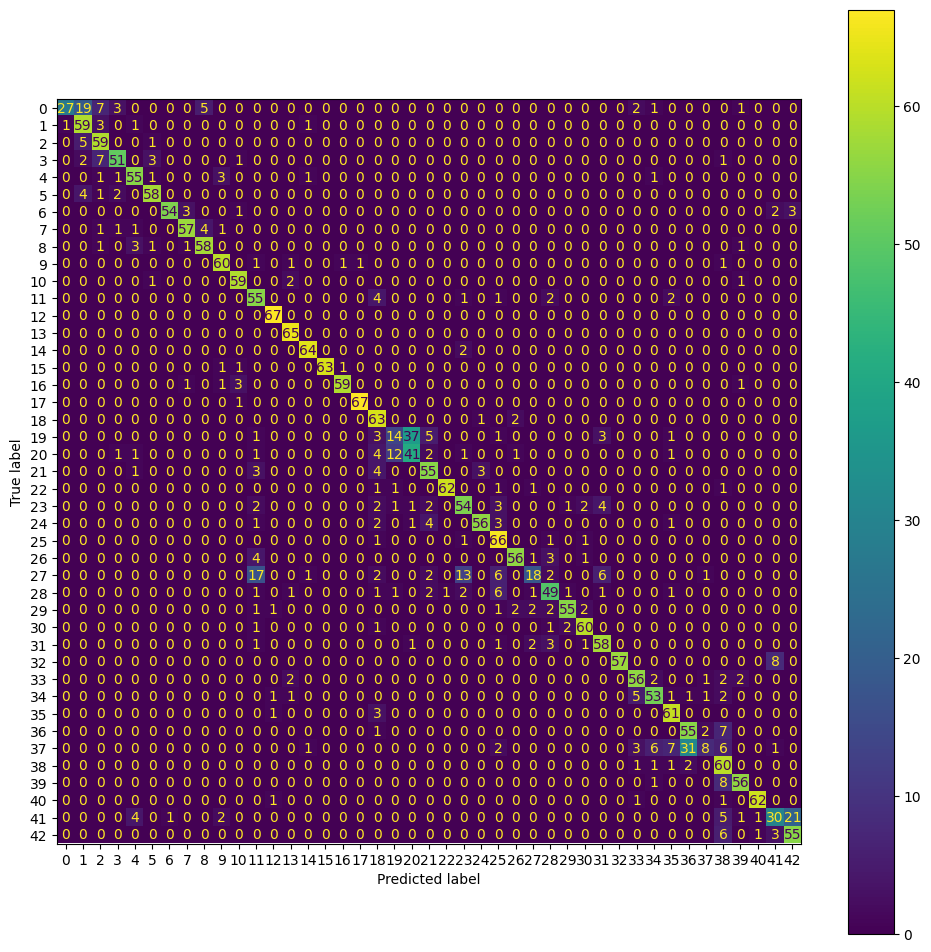

In [ ]:
# 1. get dataloader
##########
# EITHER valid
# cm_data = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))

## OR combined test
new_test = torchvision.datasets.DatasetFolder(new_test_path, loader=torch.load, extensions=('.tensor'))
our_test = torchvision.datasets.DatasetFolder(our_test_path, loader=torch.load, extensions=('.tensor'))
cm_data = torch.utils.data.ConcatDataset([new_test, our_test])
##########

cm_loader = torch.utils.data.DataLoader(cm_data, batch_size=best_batch_size, shuffle=True)

# 2. predict with model
true, pred = get_labels_and_predictions(best_model, cm_loader)

# 3. plot cm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true, pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(12,12))
ax = plt.gca()
disp.plot(ax=ax)
plt.show()

In [ ]:
train_val_set = torchvision.datasets.ImageFolder(
        root=new_train_path
    )


print(f'train_val_set size: {len(train_val_set)}')

updated_train_val_path = f'{dataset_path}/Updated_Train'
updated_train_set = torchvision.datasets.ImageFolder(
        root=updated_train_val_path
    )

print(f'updated_train_set size: {len(updated_train_set)}')

train_val_set size: 22380
updated_train_set size: 12330
